# Classification

**What is baiduspider and how would you identify it best with minimal possible errors?**

Baiduspider is a web crawler serving the Chinese search engine Baidu. According to baidu, it can be identified with having 'Baiduspider' in the User-Agent header. However, this may be used by malicious actors to hide their tracks. To double check that the origin is actually baidu, a user can do a reverse IP lookup via DNS. On Mac OS this is done with the `dig` command, and on Linux with `host ip`.

# Data Analysis 1

**The file contains recorded traffic from one of our customers after all customer's sensitive data been removed. Your challenge is to find attackers, and describe which attack they performed and how we can identify them from all the traffic. Please try to describe the entire process you made from the data processing stage to the actual findings.**

Begin by importing pandas and the data and setting up matplotlib.

In [1]:
%matplotlib inline
import pandas as pd
test_df = pd.read_csv('test_20180320.csv')

Then import json and use json_normalize to convert the Headers data into columns of the csv. Merge this back with the original data.

In [2]:
import json
headers_df = pd.io.json.json_normalize(test_df['Headers'].apply(json.loads))
merged_test_df = pd.merge(test_df, headers_df, left_index=True, right_index=True)

Convert the time from unix epoch to human-readable form and set the index to the Timestamp.

In [3]:
import datetime
merged_test_df['Timestamp'] = pd.to_datetime(test_df.Timestamp, unit='s')
merged_test_df.index = pd.to_datetime(test_df.Timestamp, unit='s')

Just for additional clarity for exploration, drop user-agent since it is the same as User-Agent, drop Headers since it has been parsed, and drop Timestamp because it is the same as the index.

In [4]:
merged_test_df = merged_test_df.drop(['user-agent','Headers','Timestamp'], 1)

## What are the columns about?

I'll begin by taking a look at summary statistics for the columns which stand out as most immediately relevant. As I discover insights from these, I will look back to these columns and others for more details and parse further to identify malicious traffic.

I will use `merged_test_df['column'].value_counts().sample(5)` to identify the top few values for each column and look for patterns and outliers.

- IP - 225.19.49.85 stands out right away with 2231 instances. Interesting that all others besides this one have exactly 5 or fewer. 
- path - /auth is most common by far, followed by first image and product pages, in ascending order.
- Accept-Language - Anything containing zh is potentially suspicious since the website is presumably in english, for an American company and zh indicates Chinese language.
- Content-Length - not sure what to make of this at first, lots of values in a smallish range, 909 is a notable outlier
- X-Forwarded-For - It is suspicious how many IPs have exactly 5
- User-Agent - Mozillia is very suspicious, since it is not a real User-Agent and shows that someone is spoofing it. The top three User-Agents overall by a significant margin are:

`Mozilla/5.0 (Linux i686) AppleWebKit/505.0 (KHTML, like Gecko) Chrome/1.0143.94 Safari/505 ` - 8902

`Mozilla/5.0 (compatible; MSIE 5.0; Linux x86_64; Tablet PC;Trident/4.0)` - 2262

`Mozilla/5.0 Chrome/156.0` - 2201

- Authorization - Basic + character string that looks like it is most likely a base64 string truncated to protect PII. Each of these instances indicates a login attempt.
- Connection - about 1/3 close, 1/3 keep alive, and 1/3 NaN - this could be useful somehow later.

Below I start looking deeper into Content-Length. I picked the top 11 instances because there is a significant gap between number of occurences of the 11th and 12th.

In [5]:
content_length_df = pd.DataFrame(merged_test_df['Content-Length'].value_counts())
top_content = content_length_df.head(11)

I will use top_content later to graph against overall traffic.

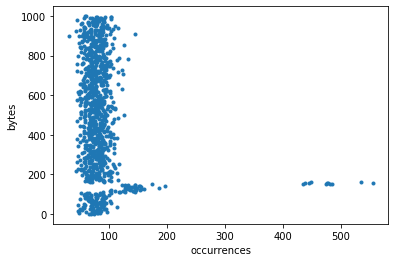

In [6]:
import matplotlib
import matplotlib.pyplot as plt


t = content_length_df['Content-Length']
o = content_length_df.index

fig, ax = plt.subplots()
ax.scatter(t, o, marker='.')

ax.set(xlabel='occurrences', ylabel='bytes')

plt.show()

In the chart above, we can see that there are several Content-Lengths which have unusually high rates of occurence, all grouped in a range between 150-160 bytes.

In [7]:
five_ip_df = merged_test_df['X-Forwarded-For'].value_counts() == 5 
five_ip_arr = []
for i in range(len(five_ip_df)):
    if five_ip_df.values[i]:
        five_ip_arr.append(five_ip_df.index[i])

Since IP and X-Forwarded for appear to stay in consistent in most 5-instance patterns I have observed, I will just use X-Forwarded-For to avoid the complication of the one outlier in IP.

The following code checks each X-Forwarded-For address with 5 requests to see if it has any pair of requests which are separated by an interval which is some multiple of 1000 seconds. Those  which are are added to `thousand_arr`. Items in this array are most likely coming from a similar source due to their similarities.

The following code block takes quite a while to run and could be made more efficient.

In [8]:
thousand_arr = []
for i in range(len(five_ip_arr)):
    temp_df = merged_test_df.loc[merged_test_df['X-Forwarded-For'] ==  five_ip_arr[i]].sort_index()
    for j in range(len(temp_df)-1):
        temp_time = (temp_df.index[j+1] - temp_df.index[j]).total_seconds()
    if temp_time % 1000 == 0: # If this IP address has two records at some multiple of 1000 seconds apart
        thousand_arr.append(five_ip_arr[i])

### Checking Subnets

Below, I will use regex to check if any of the IPs from the IP or X-Forwarded-For columns come from the same /24 networks.

In [9]:
ip_nets = merged_test_df['IP'].str.extract(r'(\d{,3}.\d{,3}.\d{,3})')
ip_nets.columns = ['network']
ip_nets['network'].value_counts().head()

225.19.49      2231
212.140.198       9
191.176.139       9
203.106.226       9
185.212.125       9
Name: network, dtype: int64

In [10]:
forward_nets = merged_test_df['X-Forwarded-For'].str.extract(r'(\d{,3}.\d{,3}.\d{,3})')
forward_nets.columns = ['network']
forward_nets['network'].value_counts().head()

170.68.145     9
141.187.104    8
139.136.204    8
170.58.188     7
101.213.49     7
Name: network, dtype: int64

Below I use resample and count to create a by-minute count of requests and then do the same for several subsets filtered by various clues to malicious behavior I have discovered while exploring the dataset.

In [11]:
overall_by_minute = merged_test_df['IP'].resample('T').count()
top_ip_by_minute = merged_test_df.loc[merged_test_df['IP'] ==  '225.19.49.85']['IP'].resample('T').count()
auth_by_minute = merged_test_df.loc[merged_test_df['path'] == '/auth']['IP'].resample('T').count()
zh_by_minute = merged_test_df.loc[merged_test_df['Accept-Language'].str.contains('zh', na = False)]['IP'].resample('T').count()
mozillia_by_minute = merged_test_df.loc[merged_test_df['User-Agent'].str.contains('Mozillia', na = False)]['IP'].resample('T').count()
tc_by_minute = merged_test_df.loc[merged_test_df["Content-Length"].isin(top_content.index)]['IP'].resample('T').count()
thousand_by_minute = merged_test_df.loc[merged_test_df["X-Forwarded-For"].isin(thousand_arr)]['IP'].resample('T').count()

In [12]:
graph_df = pd.concat([overall_by_minute, top_ip_by_minute, auth_by_minute, zh_by_minute, mozillia_by_minute, tc_by_minute, thousand_by_minute], axis=1)

In [13]:
graph_df.columns = ['overall', 'top_ip', 'auth', 'zh', 'mozillia', 'top_content', 'thousand']

/Users/tempadmin/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


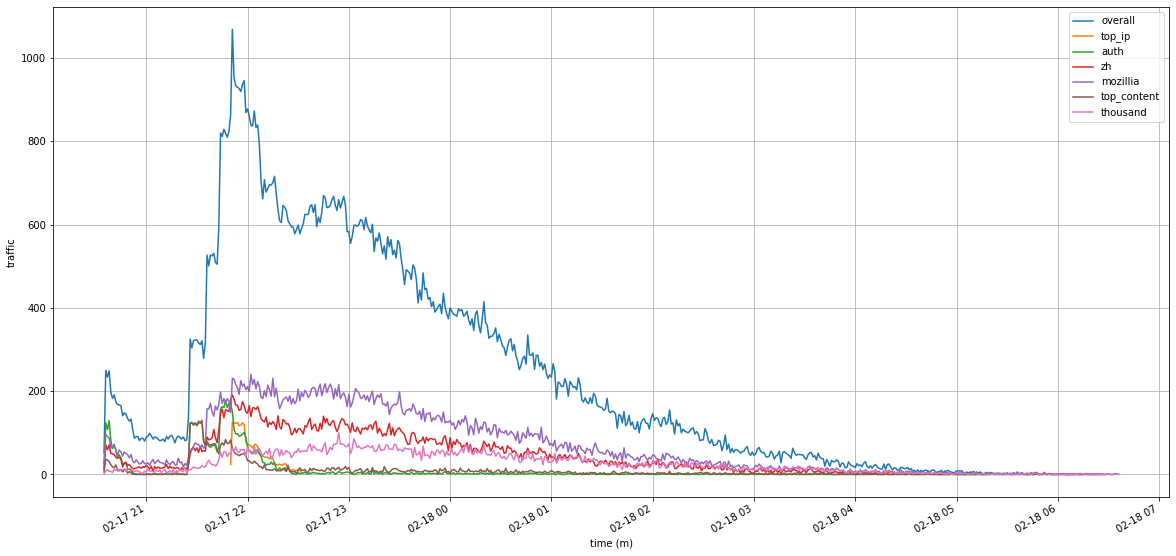

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

hours = mdates.HourLocator()
Fmt = mdates.DateFormatter('%Y')

t = graph_df.index
a = graph_df['overall']
b = graph_df['top_ip']
c = graph_df['auth']
d = graph_df['zh']
e = graph_df['mozillia']
f = graph_df['top_content']
g = graph_df['thousand']

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(t, a, label='overall')
ax.plot(t, b, label='top_ip')
ax.plot(t, c, label='auth')
ax.plot(t, d, label='zh')
ax.plot(t, e, label='mozillia')
ax.plot(t, f, label='top_content')
ax.plot(t, g, label='thousand')

ax.set(xlabel='time (m)', ylabel='traffic')
ax.grid()
ax.xaxis.set_major_locator(hours)
ax.format_xdata = mdates.DateFormatter('%Y')
fig.autofmt_xdate()

plt.legend(loc=1)
plt.show()

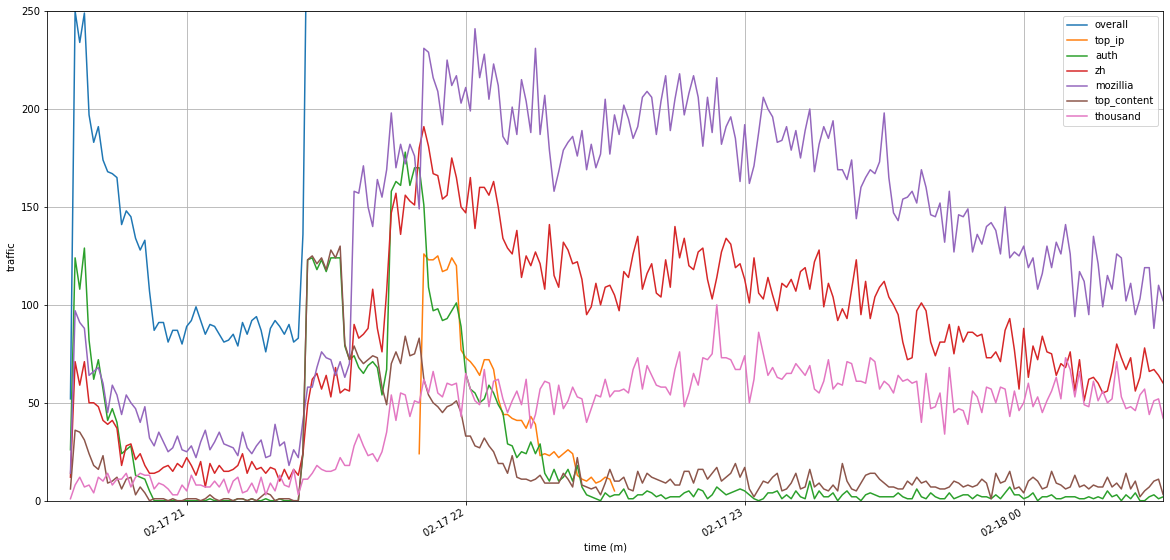

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(t, a, label='overall')
ax.plot(t, b, label='top_ip')
ax.plot(t, c, label='auth')
ax.plot(t, d, label='zh')
ax.plot(t, e, label='mozillia')
ax.plot(t, f, label='top_content')
ax.plot(t, g, label='thousand')

ax.set(xlabel='time (m)', ylabel='traffic')
ax.grid()
ax.xaxis.set_major_locator(hours)
ax.format_xdata = mdates.DateFormatter('%Y')
fig.autofmt_xdate()

left = '2015-02-17 20:30:00'
right = '2015-02-18 00:30:00'

bottom = 0
top = 250

ax.set_xlim(left, right)
ax.set_ylim(bottom, top)

plt.legend(loc=1)
plt.show()

There are a number of observations to be made from this graph, and lots of suggestions about how the data might be further explored.

- /auth requests are mostly made at the beginning, and then at a normal rate beyond two initial large spikes.
- The top IP address starts off with a lot of requests, but dwindles within 30 minutes and then stops completely.
- The typo 'Mozillia' explains the largest amount of malicious traffic, which is useful since this traffic is obviously bad.
- The unusual number of requests between 150-160 bytes in top_content look related to the /auth requests, which would be worth examining further. After the initial /auth spikes, they return to an expected 'normal' frequency.
- Requests from the same IP which are separated by some interval which is a multiple of 1000 seconds stay consistent, and this traffic also seems obviously bad. 
- Chinese language appears to be another reliable indicator of malicious behavior, but with more caveats.

The most difficult part of this question for me is identifying what kind of attack is being performed. With enough research and time, I'm sure that this dataset is rich enough to give me all the clues I need to figure it out. My guess at this stage is that this is some type of attack which is harvesting sensitive product and image data that is unique to each authenticated user. This would explain why there are so many bots requesting the same paths, and why there are so many instances of 0 indexed products and images (such as /images/id/0 and /products/id/0), with decreasing frequencies for requests as this index gets higher and higher. My theory is that the bots login as users in the first wave (/auth) of the attack, and then rotate through IP addresses while harvesting the sensitive data which requires authentication to access.

# DOM Reading
**Which of the following 10 objects are part of PerimeterX homepage?**

- a. `btn btn-default btn-b1` - Yes
- b. `jfk-bubble fkbx-chm` - No
- c. `blog-bottom-borderlink` - No
- d. `blog-link has-bottom-border` -No
- e. `spch s2fp-h` - No
- f. `button headerItem` - No
- g. `col-header` - Yes
- h. `reg-fraud` - No
- i. `_ctl0_frmMarginRightT op1` No

I first looked at the source and simply did ctrl+F for each of these. I then thought that this might not cover everything, as some objects may load later. I then tried checking for each with this jquery `$('btn btn-default btn-b1').length` in my browser's console and found the same results.

# Bot Detection

**Please list 5 ways you think about for identifying bots, without collecting private user information.**

1. Start by finding periods of abnormally high traffic, then subsequently analyze it to find out what is different between the periods when traffic spikes and 'normal' traffic.

2. Look for IP addresses or ranges which are unusually active or exist as known bad actors.

3. Some bots identify themselves, such as baiduspider, googlebot, bingbot. Look for these and for other clues in the `User-Agent` header, such as typos in the data analysis exercise.

4. Look for strange patterns in traffic, such as evenly spaced requests, requests happening faster than a human could possibly submit them, or other repeated patterns.

5. Pay particular attention when there is relatively heavier traffic in more sensitive areas of the website, such as authentication.

# Coding skills
Write a script in a language of your preference (python, javascript, etc.) that will access the following URL http://www.cool-proxy.net/proxies/http_proxy_list/sort:score/direction:desc and create a CSV of ALL IPs and ports. (not just from the landing page)

In [16]:
import urllib.request
import json
from pandas.io.json import json_normalize

with urllib.request.urlopen("https://cool-proxy.net/proxies.json") as url:
    data = json.loads(url.read().decode())

proxy_df = json_normalize(data)
final_list = proxy_df[['ip','port']]
final_list.to_csv("output_ips.csv", encoding='utf-8', index=False)

# Customer Communication

For each of the scenarios below, please provide (1) a written response to the support issues and (2) your thoughts / questions / additional information you would seek internally to better understand the issue

**“I just signed up to your service, and you guys charged my credit card, but I can’t log in. This is pretty terrible service, and I honestly would just consider asking for a refund if this can’t be solved quickly.”**

1. Written response to the support issues

I'm sorry that you're having issues logging into the service, please provide me with your email address and I will try to help you get past this as quickly as possible.

2. Thoughts / questions / additional information you would seek internally

When did they sign up? Have they contacted support before? Are there any hints about why they are angry enough to call it a 'terrible service', or are they just frustrated by their login issues?

**“An end user of a site protected by PerimeterX service has opened a ticket: “ Hi, you guys blocked my access to my Walmart account and I can’t buy my groceries. I have a party in two days and I won’t be able to buy food. Please let me access”**

1. Written response to the support issues

I would be happy to look into why we may have blocked access to your Walmart account. Could you please provide me with your account details so I can help you try to unblock it?

2. Thoughts / questions / additional information you would seek internally

Why was it blocked? Did it trigger something in the system? Is this an actual end user or someone looking to unban a malicious account? It seems unusual that a walmart customer would know and make the effort to go to PerimeterX unless they were directly informed that they were banned by the service.

**“A paying customer writes to you saying: “ Your service suddenly stopped working. My site is being scraped and my content is jeopardised.” You look into this and determine that there’s a bug in the system. Write a response to him (bonus points if you can help provide him with a workaround in case the bug isn’t fixed by tomorrow!)**

1. Written response to the support issues

We have looked into your issue and discovered a previously unknown bug in our system. We apologize for any disruption this has caused and our team is working on fixing the bug as quickly as possible. In case the bug is not fixed by tomorrow, you might want to consider some basic measures for temporarily protecting the content on your site. Depending on your situation, you may want to consider the following:
    - blocking suspicious IP addresses if you can find any (although this is very simple for attackers to circumvent)
    - requiring CAPTCHA authentication for sensitive content
    - changing the structure of your webpage to confound previously configured bots which might be scraping your site
    - limiting request frequency or the amount of data a user is allowed to download

2. Thoughts / questions / additional information you would seek internally

What is the bug? How long has it been in the codebase? How long will it likely take to fix and update?

**An enterprise customer has sent an email to support, complaining about slow response, bad service, and threatening to leave. What would you do?**

1. Written response to the support issues

I'm sorry that you have been frustrated with your customer service experience at PerimeterX in the past. I would like to address this personally and find a way that we can resolve your issues. 

2. Thoughts / questions / additional information you would seek internally

Records about support history - how long have they waited? Have they had particularly hard questions for support? Have they receieved bad service, and if so, how? Would it help if they talked to someone higher up in the company? How much is the customer worth to the company, and should there be more attention paid to their issues?